<a href="https://colab.research.google.com/github/zlewe/ml-course/blob/master/ResNet50_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive and import dependencies

In [21]:
from  google.colab  import  drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [23]:
keras.__version__

'2.2.4'

# Create Keras data generators

In [24]:
datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/MLResnet/data',
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    subset='training')

validation_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/MLResnet/data',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    subset='validation')

Found 1006 images belonging to 7 classes.
Found 426 images belonging to 7 classes.


# Create the network

In [25]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(7, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [0]:
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Training

In [29]:
history = model.fit_generator(generator=train_generator,
                              epochs=3,
                              steps_per_epoch=32,
                              validation_data=validation_generator,
                              validation_steps=14)

Epoch 1/3
32/32 [==============================] - 23s 721ms/step - loss: 0.6350 - acc: 0.7899 - val_loss: 0.7620 - val_acc: 0.7488
Epoch 2/3
32/32 [==============================] - 19s 598ms/step - loss: 0.2007 - acc: 0.9392 - val_loss: 0.9976 - val_acc: 0.7042
Epoch 3/3
32/32 [==============================] - 19s 607ms/step - loss: 0.1695 - acc: 0.9504 - val_loss: 0.7102 - val_acc: 0.7958


# Predict

In [0]:
validation_img_paths = ["/content/drive/My Drive/MLResnet/data/bar/bar (1).jpg",
                        "/content/drive/My Drive/MLResnet/data/bubble/bubble (1).jpg",
                        "/content/drive/My Drive/MLResnet/data/pie/pie (1).jpg",
                       "/content/drive/My Drive/MLResnet/data/fool/fool (1).jpg",
                        "/content/drive/My Drive/MLResnet/data/histogram/histogram (1).jpg",
                        "/content/drive/My Drive/MLResnet/data/line/line (1).jpg",
                       "/content/drive/My Drive/MLResnet/data/scatter/scatter (1).jpg",
                        "/content/drive/My Drive/MLResnet/data/bubble/bubble (15).jpg",
                        "/content/drive/My Drive/MLResnet/data/pie/pie (30).jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [0]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [0]:
pred_probs = model.predict(validation_batch)

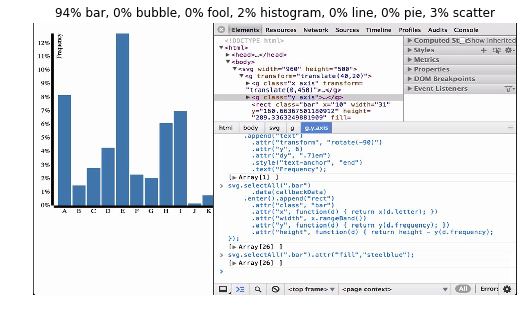

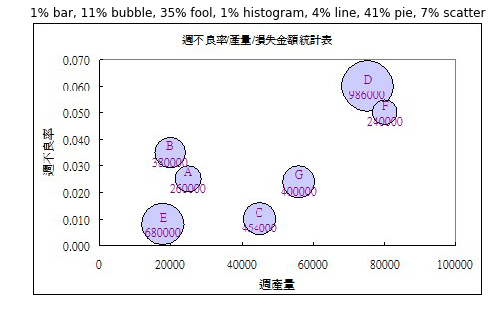

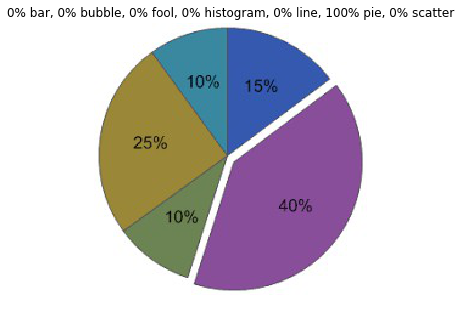

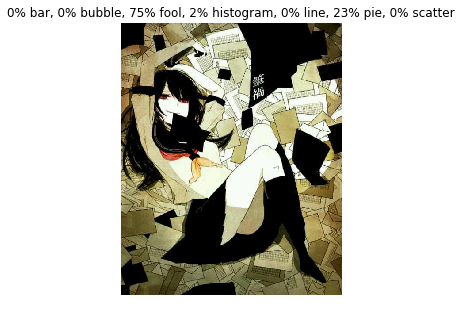

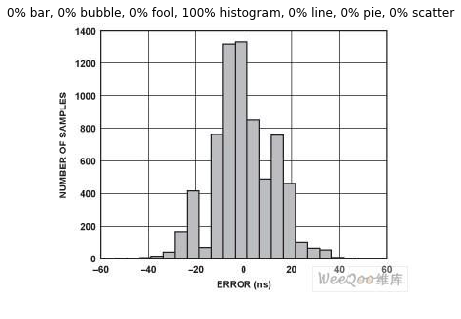

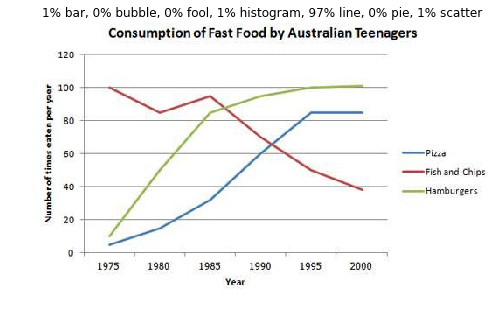

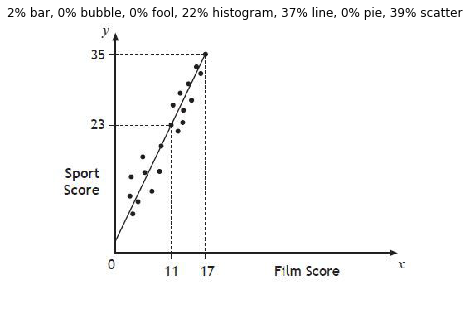

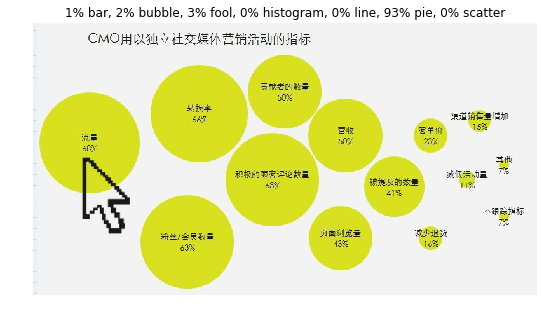

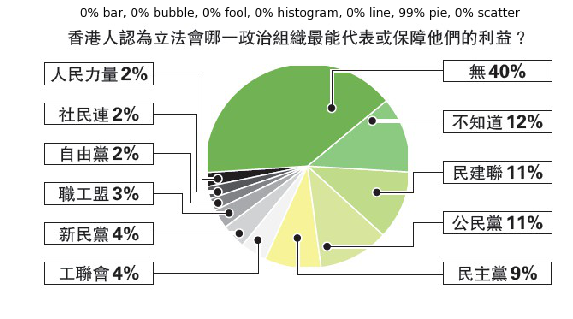

In [62]:
for i, img in enumerate(img_list):
  fig, ax = plt.subplots(1, figsize=(20, 5))
  ax.axis('off')
  ax.set_title("{:.0f}% bar, {:.0f}% bubble, {:.0f}% fool, {:.0f}% histogram, {:.0f}% line, {:.0f}% pie, {:.0f}% scatter".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1], 100*pred_probs[i,2],
                                                          100*pred_probs[i,3], 100*pred_probs[i,4],
                                                          100*pred_probs[i,5], 100*pred_probs[i,6]))
  ax.imshow(img)

# Save Model

In [0]:
# architecture and weights to HDF5
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
        f.write(model.to_json())

In [0]:
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

# Confusion Matrix and Classification Report

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
Y_pred = model.predict_generator(validation_generator, 426 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['ca', 'Dogs', 'Horse','a','b','v','e']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[16  0  1 33  4  1  1]
 [ 2  0  0  2 41  9  6]
 [ 0  1  0  0  1 69  7]
 [ 9  0  0  0  1  0 39]
 [48  4  0  1  0  1  2]
 [ 4 44 13  3  3  7  5]
 [ 2  3 20 10  9  3  1]]
Classification Report
              precision    recall  f1-score   support

          ca       0.20      0.29      0.23        56
        Dogs       0.00      0.00      0.00        60
       Horse       0.00      0.00      0.00        78
           a       0.00      0.00      0.00        49
           b       0.00      0.00      0.00        56
           v       0.08      0.09      0.08        79
           e       0.02      0.02      0.02        48

   micro avg       0.06      0.06      0.06       426
   macro avg       0.04      0.06      0.05       426
weighted avg       0.04      0.06      0.05       426



In [0]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()